# Supervised Pipeline

## SVM

VIF Results After Dropping Features:
                 feature       VIF
0  ACTUALTERMTOMATURITY  1.903104
1                COUPON  4.074414
2   ADDITIONALPURCHASED  1.123887
3          TOTALFUNDING  3.360638
4            COVERRATIO  3.693616
5      GROSSCUTOFFYIELD  4.639008
Accuracy: 0.8160621761658031
Precision: 0.8192526016360213
Recall: 0.6620208527105078
F1 Score: 0.8052188751148128


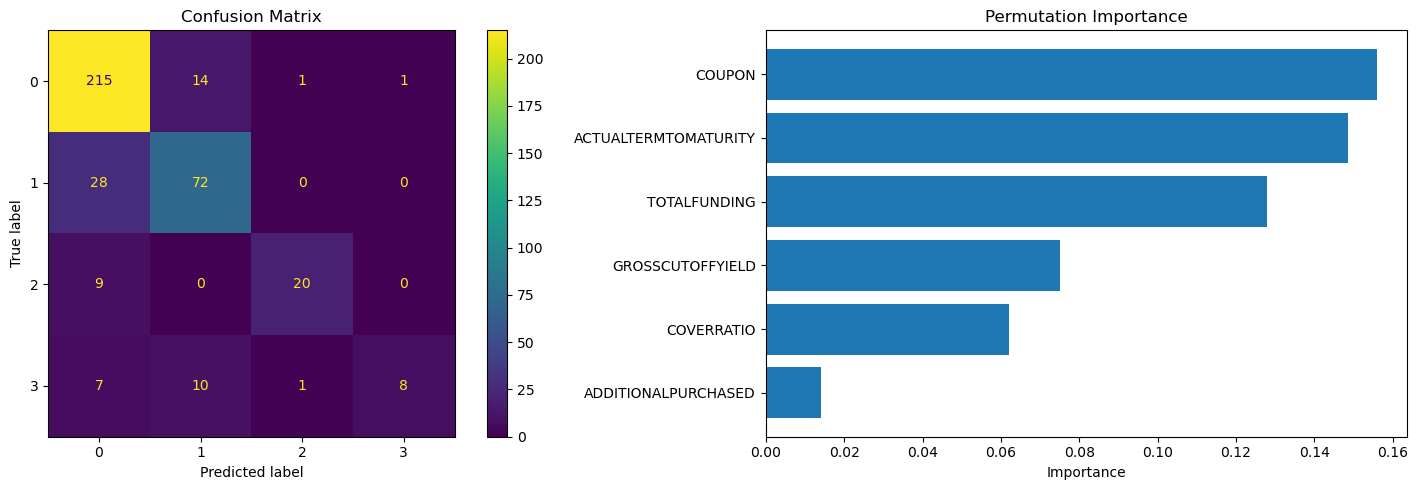

In [689]:
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Function to calculate VIF and cleaning
def vif(df):
    max_val = float('inf')
    while max_val > 5:
        vif_data = pd.DataFrame()
        X = df.select_dtypes(include=['float64', 'int64'])
        vif_data["feature"] = X.columns

        # calculating VIF for each feature
        vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                           for i in range(len(X.columns))]
        max_val = max(vif_data["VIF"])
        for index, item in enumerate(vif_data['VIF']):
            if item >= max_val and max_val > 5:
                df = df.drop(vif_data.iloc[index, 0], axis=1)
    return df, vif_data

# Load dataset
df = pd.read_csv('file.csv', encoding='windows-1255')

# Remove date columns
date_columns = df.select_dtypes(include=['object']).columns[df.select_dtypes(include=['object']).columns.str.contains('date', case=False, na=False)]
df = df.drop(columns=date_columns)

# Replace values in 'BONDS'
replacements = {
    'ממשלתית': 'GOV',
    'ממשלתית בריבית משתנה': 'GOV_VAR',
    'ממשלתית צמודה': 'GOV_INDEX',
    'ממשלתית קצרה': 'GOV_SHORT'
}
df['BONDS'] = df['BONDS'].map(replacements)

# Separate features and target for VIF calculation
df_features = df.drop(columns=['BONDS'])

# Calculate VIF and update features
df_features, vif_result = vif(df_features)
print("VIF Results After Dropping Features:\n", vif_result)

# Add the target column back to the dataset
df_scaled = pd.concat([df_features, df[['BONDS']]], axis=1)

# Separate features and target for modeling
X = df_scaled.drop(columns=['BONDS'])
y = df_scaled['BONDS']

# Define preprocessing for numerical and categorical data
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

# Define the model
clf = svm.SVC(kernel='rbf')

# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', clf)
])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred = pipeline.predict(X_test)

# Model Accuracy: how often is the classifier correct?
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:", metrics.precision_score(y_test, y_pred, average='weighted'))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:", metrics.recall_score(y_test, y_pred, average='macro'))

print("F1 Score:", metrics.f1_score(y_test, y_pred, average='weighted'))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Permutation Importance
perm_importance = permutation_importance(pipeline, X_test, y_test)

feature_names = X.columns
features = np.array(feature_names)

sorted_idx = perm_importance.importances_mean.argsort()

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ConfusionMatrixDisplay(cm).plot(ax=ax[0], cmap='viridis')
ax[0].set_title("Confusion Matrix")

ax[1].barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
ax[1].set_title("Permutation Importance")
ax[1].set_xlabel("Importance")

plt.tight_layout()
plt.show()

## xgboost

VIF Results After Dropping Features:
                 feature       VIF
0  ACTUALTERMTOMATURITY  1.903104
1                COUPON  4.074414
2   ADDITIONALPURCHASED  1.123887
3          TOTALFUNDING  3.360638
4            COVERRATIO  3.693616
5      GROSSCUTOFFYIELD  4.639008
Label Mapping: {'GOV': 0, 'GOV_INDEX': 1, 'GOV_SHORT': 2, 'GOV_VAR': 3}
Accuracy: 0.9896373056994818
Precision: 0.9898136919854481
Recall: 0.9686538461538462
F1 Score: 0.9894373525504309


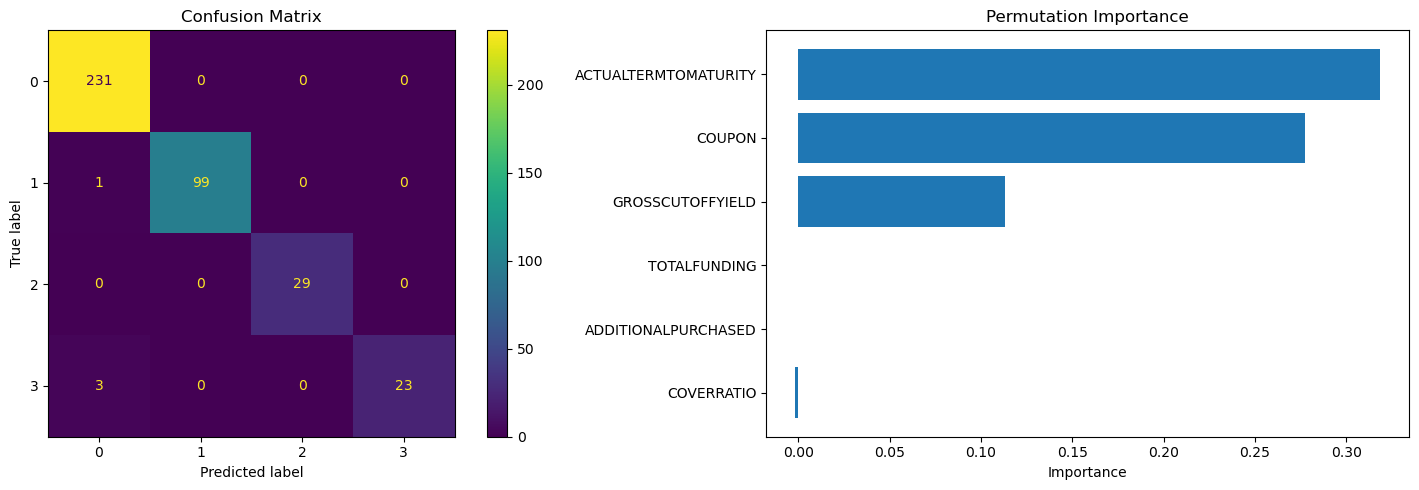

In [691]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Function to calculate VIF and clean features
def vif(df):
    max_val = float('inf')
    while max_val > 5:
        vif_data = pd.DataFrame()
        X = df.select_dtypes(include=['float64', 'int64'])
        vif_data["feature"] = X.columns

        # Calculate VIF for each feature
        vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                           for i in range(len(X.columns))]
        max_val = max(vif_data["VIF"])
        for index, item in enumerate(vif_data['VIF']):
            if item >= max_val and max_val > 5:
                df = df.drop(vif_data.iloc[index, 0], axis=1)
    return df, vif_data

# Load dataset
df = pd.read_csv('file.csv', encoding='windows-1255')

# Remove date columns
date_columns = df.select_dtypes(include=['object']).columns[df.select_dtypes(include=['object']).columns.str.contains('date', case=False, na=False)]
df = df.drop(columns=date_columns)

# Map BONDS column
replacements = {
    'ממשלתית': 'GOV',
    'ממשלתית בריבית משתנה': 'GOV_VAR',
    'ממשלתית צמודה': 'GOV_INDEX',
    'ממשלתית קצרה': 'GOV_SHORT'
}
df['BONDS'] = df['BONDS'].map(replacements)

# Separate features and target for VIF calculation
df_features = df.drop(columns=['BONDS'])

# Calculate VIF and update features
df_features, vif_result = vif(df_features)
print("VIF Results After Dropping Features:\n", vif_result)

# Add the target column back to the dataset
df_scaled = pd.concat([df_features, df[['BONDS']]], axis=1)

# Separate features and target for modeling
X = df_scaled.drop(columns=['BONDS'])
y = df_scaled['BONDS']

# Convert y to numeric using LabelEncoder
encoder = LabelEncoder()
y = encoder.fit_transform(y)

# Print label mapping
label_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
print("Label Mapping:", label_mapping)

# Define preprocessing for numerical and categorical data
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

# Define the model
xgb_model = xgb.XGBClassifier(objective="multi:softprob", random_state=42)

# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),       # Preprocessing step
    ('classifier', xgb_model)             # Classification model
])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred = pipeline.predict(X_test)

# Model evaluation
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred, average='weighted'))
print("Recall:", metrics.recall_score(y_test, y_pred, average='macro'))
print("F1 Score:", metrics.f1_score(y_test, y_pred, average='weighted'))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Permutation Importance
perm_importance = permutation_importance(pipeline, X_test, y_test)

feature_names = X.columns
features = np.array(feature_names)

sorted_idx = perm_importance.importances_mean.argsort()

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ConfusionMatrixDisplay(cm).plot(ax=ax[0], cmap='viridis')
ax[0].set_title("Confusion Matrix")

ax[1].barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
ax[1].set_title("Permutation Importance")
ax[1].set_xlabel("Importance")

plt.tight_layout()
plt.show()


## RF

VIF Results After Dropping Features:
                 feature       VIF
0  ACTUALTERMTOMATURITY  1.903104
1                COUPON  4.074414
2   ADDITIONALPURCHASED  1.123887
3          TOTALFUNDING  3.360638
4            COVERRATIO  3.693616
5      GROSSCUTOFFYIELD  4.639008
Accuracy: 0.9896373056994818
Precision: 0.9898136919854481
Recall: 0.9757692307692307
F1 Score: 0.9895519854193606


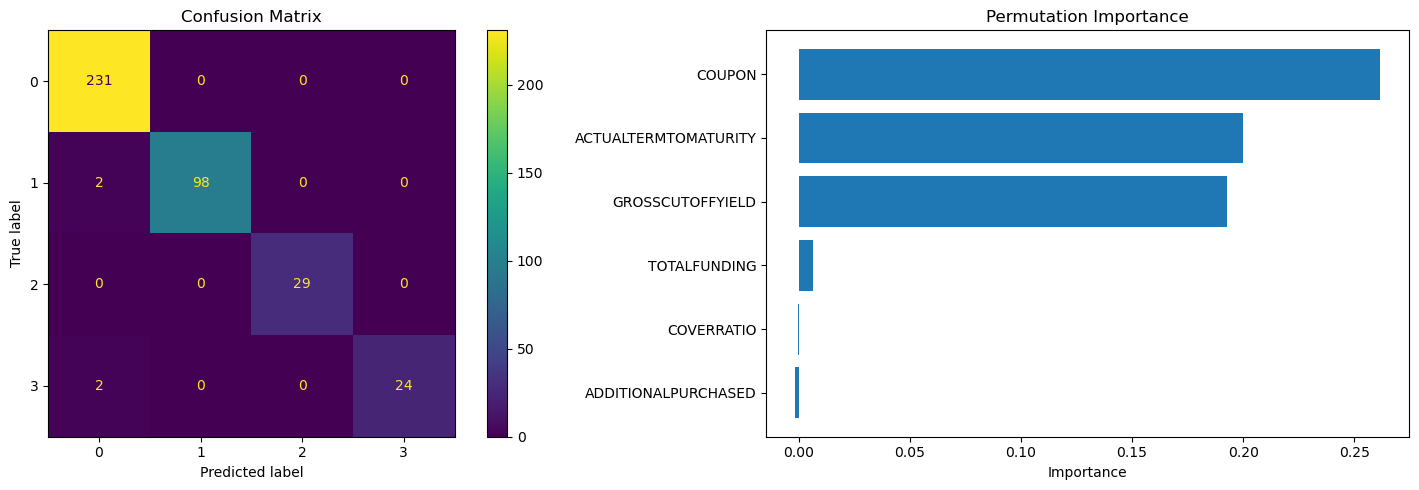

In [693]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Function to calculate VIF and cleaning
def vif(df):
    max_val = float('inf')
    while max_val > 5:
        vif_data = pd.DataFrame()
        X = df.select_dtypes(include=['float64', 'int64'])
        vif_data["feature"] = X.columns

        # calculating VIF for each feature
        vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                           for i in range(len(X.columns))]
        max_val = max(vif_data["VIF"])
        for index, item in enumerate(vif_data['VIF']):
            if item >= max_val and max_val > 5:
                df = df.drop(vif_data.iloc[index, 0], axis=1)
    return df, vif_data

# Load dataset
df = pd.read_csv('file.csv', encoding='windows-1255')

# Remove date columns
date_columns = df.select_dtypes(include=['object']).columns[df.select_dtypes(include=['object']).columns.str.contains('date', case=False, na=False)]
df = df.drop(columns=date_columns)

# Replace values in 'BONDS'
replacements = {
    'ממשלתית': 'GOV',
    'ממשלתית בריבית משתנה': 'GOV_VAR',
    'ממשלתית צמודה': 'GOV_INDEX',
    'ממשלתית קצרה': 'GOV_SHORT'
}
df['BONDS'] = df['BONDS'].map(replacements)

# Separate features and target for VIF calculation
df_features = df.drop(columns=['BONDS'])

# Calculate VIF and update features
df_features, vif_result = vif(df_features)
print("VIF Results After Dropping Features:\n", vif_result)

# Add the target column back to the dataset
df_scaled = pd.concat([df_features, df[['BONDS']]], axis=1)

# Separate features and target for modeling
X = df_scaled.drop(columns=['BONDS'])
y = df_scaled['BONDS']

# Define preprocessing for numerical and categorical data
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

# Define the model
rf = RandomForestClassifier()

# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', rf)
])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred = pipeline.predict(X_test)

# Model Accuracy: how often is the classifier correct?
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:", metrics.precision_score(y_test, y_pred, average='weighted'))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:", metrics.recall_score(y_test, y_pred, average='macro'))

print("F1 Score:", metrics.f1_score(y_test, y_pred, average='weighted'))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Permutation Importance
perm_importance = permutation_importance(pipeline, X_test, y_test)

feature_names = X.columns
features = np.array(feature_names)

sorted_idx = perm_importance.importances_mean.argsort()

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ConfusionMatrixDisplay(cm).plot(ax=ax[0], cmap='viridis')
ax[0].set_title("Confusion Matrix")

ax[1].barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
ax[1].set_title("Permutation Importance")
ax[1].set_xlabel("Importance")

plt.tight_layout()
plt.show()

## KNN

VIF Results After Dropping Features:
                 feature       VIF
0  ACTUALTERMTOMATURITY  1.903104
1                COUPON  4.074414
2   ADDITIONALPURCHASED  1.123887
3          TOTALFUNDING  3.360638
4            COVERRATIO  3.693616
5      GROSSCUTOFFYIELD  4.639008
Accuracy: 0.9300518134715026
Precision: 0.9286319830732791
Recall: 0.8341232043818251
F1 Score: 0.9279355656266398


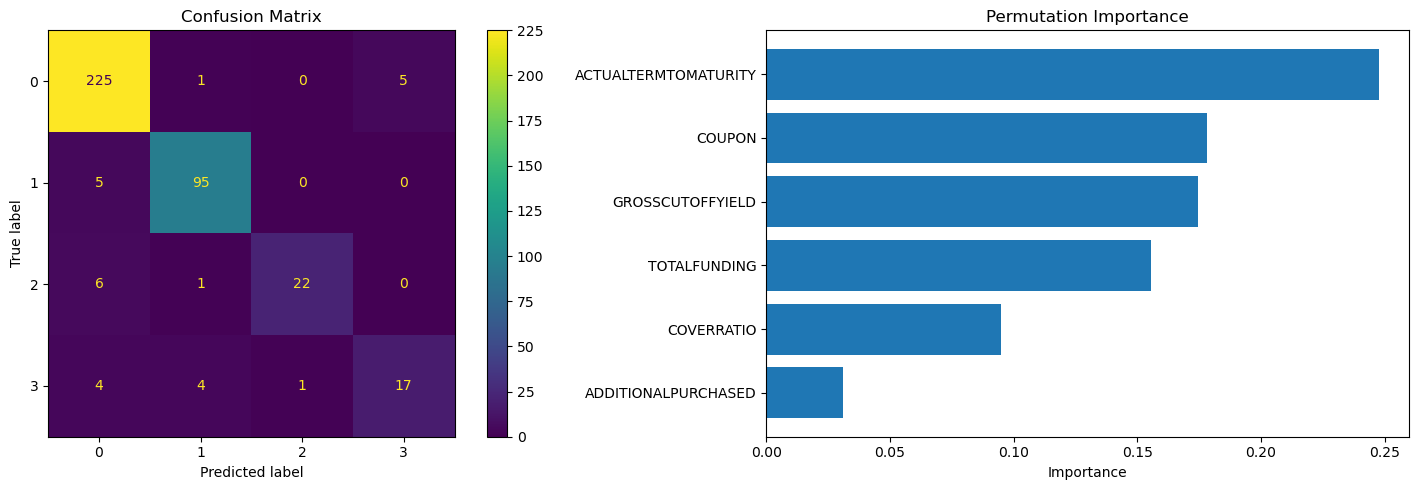

In [695]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Function to calculate VIF and cleaning
def vif(df):
    max_val = float('inf')
    while max_val > 5:
        vif_data = pd.DataFrame()
        X = df.select_dtypes(include=['float64', 'int64'])
        vif_data["feature"] = X.columns

        # calculating VIF for each feature
        vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                           for i in range(len(X.columns))]
        max_val = max(vif_data["VIF"])
        for index, item in enumerate(vif_data['VIF']):
            if item >= max_val and max_val > 5:
                df = df.drop(vif_data.iloc[index, 0], axis=1)
    return df, vif_data

# Load dataset
df = pd.read_csv('file.csv', encoding='windows-1255')

# Remove date columns
date_columns = df.select_dtypes(include=['object']).columns[df.select_dtypes(include=['object']).columns.str.contains('date', case=False, na=False)]
df = df.drop(columns=date_columns)

# Replace values in 'BONDS'
replacements = {
    'ממשלתית': 'GOV',
    'ממשלתית בריבית משתנה': 'GOV_VAR',
    'ממשלתית צמודה': 'GOV_INDEX',
    'ממשלתית קצרה': 'GOV_SHORT'
}
df['BONDS'] = df['BONDS'].map(replacements)

# Separate features and target for VIF calculation
df_features = df.drop(columns=['BONDS'])

# Calculate VIF and update features
df_features, vif_result = vif(df_features)
print("VIF Results After Dropping Features:\n", vif_result)

# Add the target column back to the dataset
df_scaled = pd.concat([df_features, df[['BONDS']]], axis=1)

# Separate features and target for modeling
X = df_scaled.drop(columns=['BONDS'])
y = df_scaled['BONDS']

# Define preprocessing for numerical and categorical data
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

# Define the model
knn = KNeighborsClassifier(n_neighbors=2)

# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', knn)
])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred = pipeline.predict(X_test)

# Model Accuracy: how often is the classifier correct?
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:", metrics.precision_score(y_test, y_pred, average='weighted'))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:", metrics.recall_score(y_test, y_pred, average='macro'))

print("F1 Score:", metrics.f1_score(y_test, y_pred, average='weighted'))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Permutation Importance
perm_importance = permutation_importance(pipeline, X_test, y_test)

feature_names = X.columns
features = np.array(feature_names)

sorted_idx = perm_importance.importances_mean.argsort()

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ConfusionMatrixDisplay(cm).plot(ax=ax[0], cmap='viridis')
ax[0].set_title("Confusion Matrix")

ax[1].barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
ax[1].set_title("Permutation Importance")
ax[1].set_xlabel("Importance")

plt.tight_layout()
plt.show()

# T-SNE

In [635]:
df

,BONDS,SERIES,ACTUALTERMTOMATURITY,ORIGINALTERMTOMATURITY,COUPON,OFFEREDQUANTITY,PURCHASEDQUANTITY,ADDITIONALPURCHASED,AVERAGEPRICE,CUTOFFPRICE,TOTALFUNDING,DEMANDEDAMOUNT,COVERRATIO,GROSSAVGYIELD,GROSSCUTOFFYIELD
0,GOV,1184076,28.0,31,2.80,116.2,116.2,0.0,67.86,67.86,78.87,116.2,1.0,5.19,5.19
1,GOV,1202332,10.4,11,4.00,150.0,150.0,0.0,96.50,96.50,144.75,150.0,1.0,4.75,4.75
2,GOV,1203579,2.9,4,3.75,131.2,14.6,-116.6,98.54,98.54,14.40,14.6,0.1,4.50,4.50
3,GOV,1212893,4.8,5,4.60,163.5,159.2,-4.3,100.21,100.21,159.54,159.2,1.0,4.60,4.60
4,GOV_INDEX,1197326,3.9,5,1.10,136.5,136.5,0.0,101.06,101.06,137.95,136.5,1.0,2.04,2.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1923,GOV_VAR,1141795,6.4,9,0.13,56.6,46.4,-10.2,99.40,99.40,46.11,46.4,0.8,0.23,0.23
1924,GOV,1155068,3.9,5,1.50,250.0,250.0,0.0,104.70,104.68,261.75,938.0,3.8,0.33,0.33
1925,GOV,1158104,2.6,3,0.75,250.0,250.0,0.0,101.72,101.71,254.30,1345.0,5.4,0.21,0.21
1926,GOV_INDEX,1157023,9.4,10,0.50,250.0,250.0,0.0,112.13,112.11,280.33,1312.0,5.2,-0.07,-0.07


In [636]:
col_to_scale = df.columns.drop('BONDS')
data_scaled = df.copy()
scaler = StandardScaler()
data_scaled[col_to_scale] = scaler.fit_transform(data_scaled[col_to_scale])
data_scaled

,BONDS,SERIES,ACTUALTERMTOMATURITY,ORIGINALTERMTOMATURITY,COUPON,OFFEREDQUANTITY,PURCHASEDQUANTITY,ADDITIONALPURCHASED,AVERAGEPRICE,CUTOFFPRICE,TOTALFUNDING,DEMANDEDAMOUNT,COVERRATIO,GROSSAVGYIELD,GROSSCUTOFFYIELD
0,GOV,0.582266,2.192388,2.256391,1.060530,-0.837412,-0.739825,0.380462,-2.817428,-2.813133,-0.896934,-0.897927,-0.983577,1.777729,1.773128
1,GOV,1.628637,0.101104,0.005604,1.904291,-0.679762,-0.588632,0.380462,-0.192099,-0.188148,-0.597872,-0.868563,-0.983577,1.532986,1.528623
2,GOV,1.700111,-0.790068,-0.782172,1.728507,-0.767449,-1.194299,-2.754777,-0.005100,-0.001173,-1.189595,-0.986193,-1.392428,1.393927,1.389700
3,GOV,2.233957,-0.564304,-0.669633,2.326172,-0.616795,-0.547479,0.264840,0.147983,0.151890,-0.530733,-0.860571,-0.983577,1.449551,1.445269
4,GOV_INDEX,1.341711,-0.671245,-0.669633,-0.134799,-0.742729,-0.649020,0.380462,0.225900,0.229796,-0.628740,-0.880291,-0.983577,0.025590,0.022695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1923,GOV_VAR,-1.841135,-0.374188,-0.219475,-0.816840,-1.115399,-1.052052,0.106196,0.073734,0.077650,-1.045647,-0.958566,-1.074433,-0.981194,-0.983110
1924,GOV,-1.080372,-0.671245,-0.669633,0.146455,-0.213341,-0.141315,0.380462,0.559566,0.561585,-0.066751,-0.183982,0.288400,-0.925571,-0.927540
1925,GOV,-0.906359,-0.825715,-0.894711,-0.380896,-0.213341,-0.141315,0.380462,0.286400,0.289371,-0.100570,0.169602,1.015245,-0.992319,-0.994224
1926,GOV_INDEX,-0.968318,-0.017719,-0.106936,-0.556680,-0.213341,-0.141315,0.380462,1.240648,1.242578,0.017593,0.140933,0.924389,-1.148065,-1.149818


In [640]:
# Load the important packages
from sklearn.manifold import TSNE

# Load the datasets
X = data_scaled.drop(columns=['BONDS'])
y = data_scaled['BONDS']

In [649]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)
tsne.kl_divergence_

0.4451768398284912

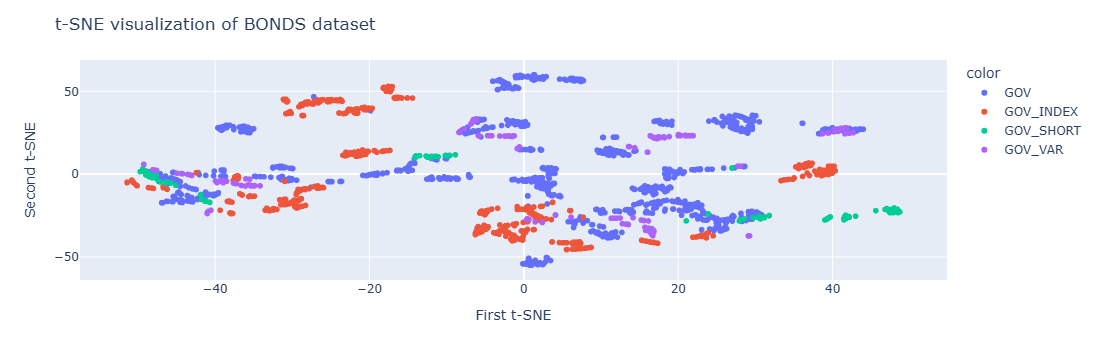

In [651]:
fig = px.scatter(x=X_tsne[:, 0], y=X_tsne[:, 1], color=y)
fig.update_layout(
    title="t-SNE visualization of BONDS dataset",
    xaxis_title="First t-SNE",
    yaxis_title="Second t-SNE",
)
fig.show()

# Unsupervised Analysis

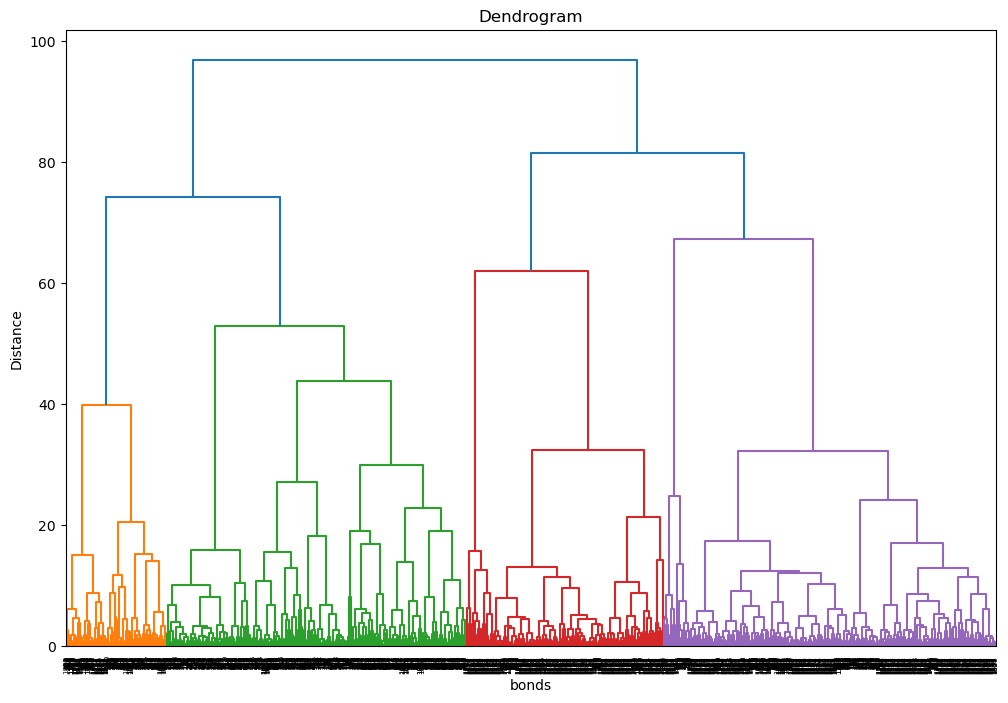

In [555]:
import scipy.cluster.hierarchy as sch
unsuper_data = data_scaled.drop(columns=['BONDS'])
plt.figure(figsize = (12, 8))
dendogram = sch.dendrogram(sch.linkage(unsuper_data, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('bonds')
plt.ylabel('Distance')
plt.show()

In [561]:
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters = 4, metric = 'euclidean', linkage = 'ward')

# Fit the model with data and predict
y_pc_hc = hc.fit_predict(unsuper_data)
y_pc_hc

array([3, 1, 1, ..., 0, 0, 0], dtype=int64)

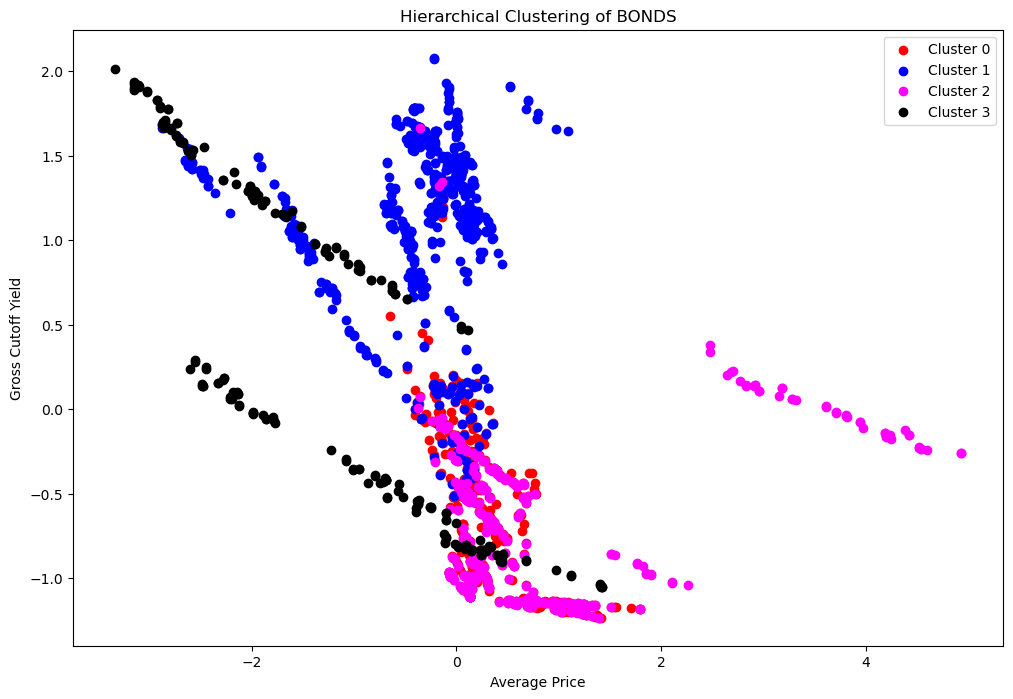

In [565]:
X_pc_hc = unsuper_data.copy() # copy data
X_pc_hc['cluster'] = y_pc_hc #append cluster label form model prediction to new dataset
X_pc_hc.head()

# Visualization 2D
plt.figure(figsize = (12, 8))
plt.scatter(X_pc_hc.loc[X_pc_hc['cluster'] == 0, 'AVERAGEPRICE'], X_pc_hc.loc[X_pc_hc['cluster'] == 0, 'GROSSCUTOFFYIELD'], c = 'red', label = 'Cluster 0')
plt.scatter(X_pc_hc.loc[X_pc_hc['cluster'] == 1, 'AVERAGEPRICE'], X_pc_hc.loc[X_pc_hc['cluster'] == 1, 'GROSSCUTOFFYIELD'], c = 'blue', label = 'Cluster 1')
plt.scatter(X_pc_hc.loc[X_pc_hc['cluster'] == 2, 'AVERAGEPRICE'], X_pc_hc.loc[X_pc_hc['cluster'] == 2, 'GROSSCUTOFFYIELD'], c = 'magenta', label = 'Cluster 2')
plt.scatter(X_pc_hc.loc[X_pc_hc['cluster'] == 3, 'AVERAGEPRICE'], X_pc_hc.loc[X_pc_hc['cluster'] == 3, 'GROSSCUTOFFYIELD'], c = 'black', label = 'Cluster 3')
plt.title('Hierarchical Clustering of BONDS')
plt.xlabel('Average Price')
plt.ylabel('Gross Cutoff Yield')
plt.legend()
plt.show()

# K-Means

In [567]:
from sklearn.cluster import KMeans

In [569]:
wcss = []
cl_num=len(unsuper_data.columns)
for i in range (1,cl_num):
    kmeans= KMeans(i)
    kmeans.fit(unsuper_data)
    wcss_iter = kmeans.inertia_
    wcss.append(wcss_iter)

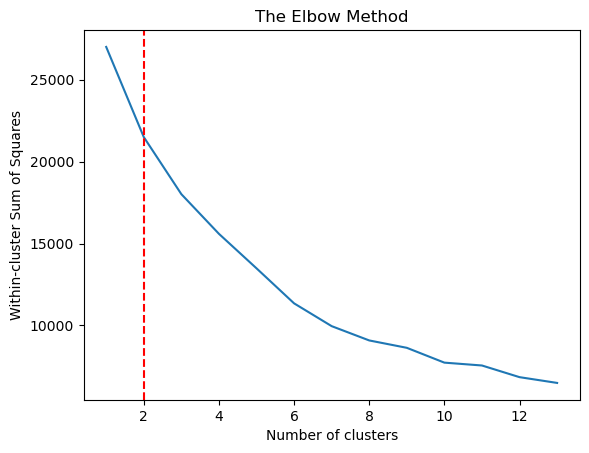

In [573]:
number_clusters = range(1,cl_num)
plt.plot(number_clusters, wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Within-cluster Sum of Squares')
optimal_k = 2
plt.axvline(x=optimal_k, color='r', linestyle='--', label=f'Optimal k={optimal_k}')

In [577]:
k_means=KMeans(n_clusters=2,random_state=42)
k_means.fit(unsuper_data)

KMeans(n_clusters=2, random_state=42)

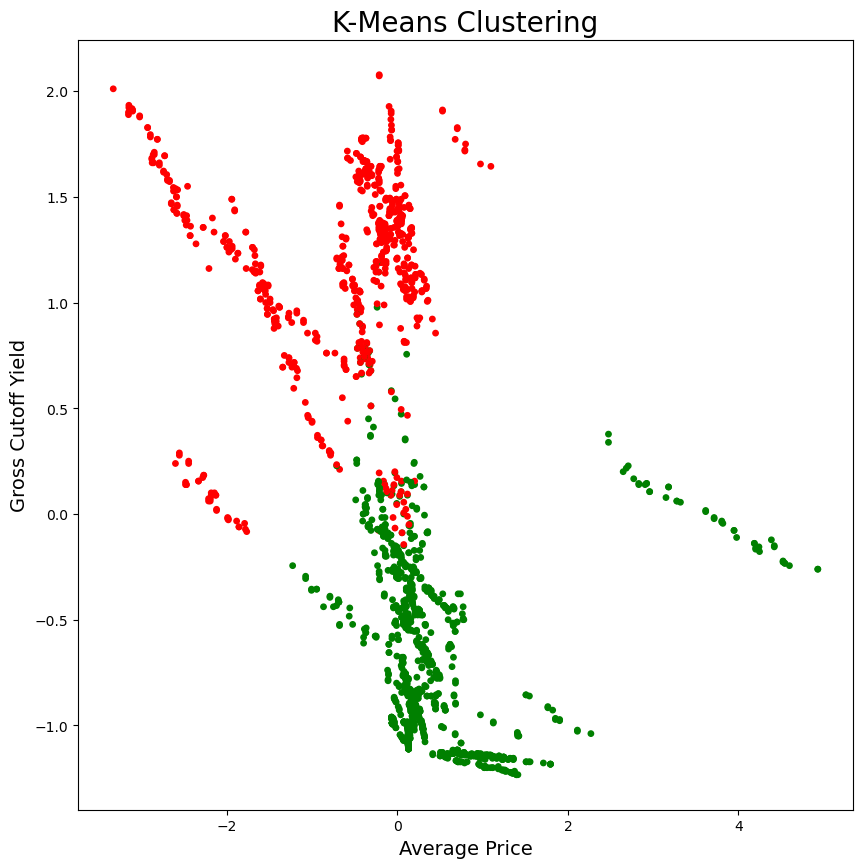

In [579]:
import matplotlib.colors
df['KMeans_labels']=k_means.labels_

# Plotting resulting clusters
colors=['red','blue','green']
plt.figure(figsize=(10,10))
plt.scatter(unsuper_data['AVERAGEPRICE'],unsuper_data['GROSSCUTOFFYIELD'],c=df['KMeans_labels'],cmap=matplotlib.colors.ListedColormap(colors),s=15)
plt.title('K-Means Clustering',fontsize=20)
plt.xlabel('Average Price',fontsize=14)
plt.ylabel('Gross Cutoff Yield',fontsize=14)
plt.show()

# DBSCAN

In [581]:
from sklearn.cluster import DBSCAN
dbscan=DBSCAN()
dbscan_labels = dbscan.fit_predict(unsuper_data)
unsuper_data['DBSCAN_labels'] = dbscan_labels

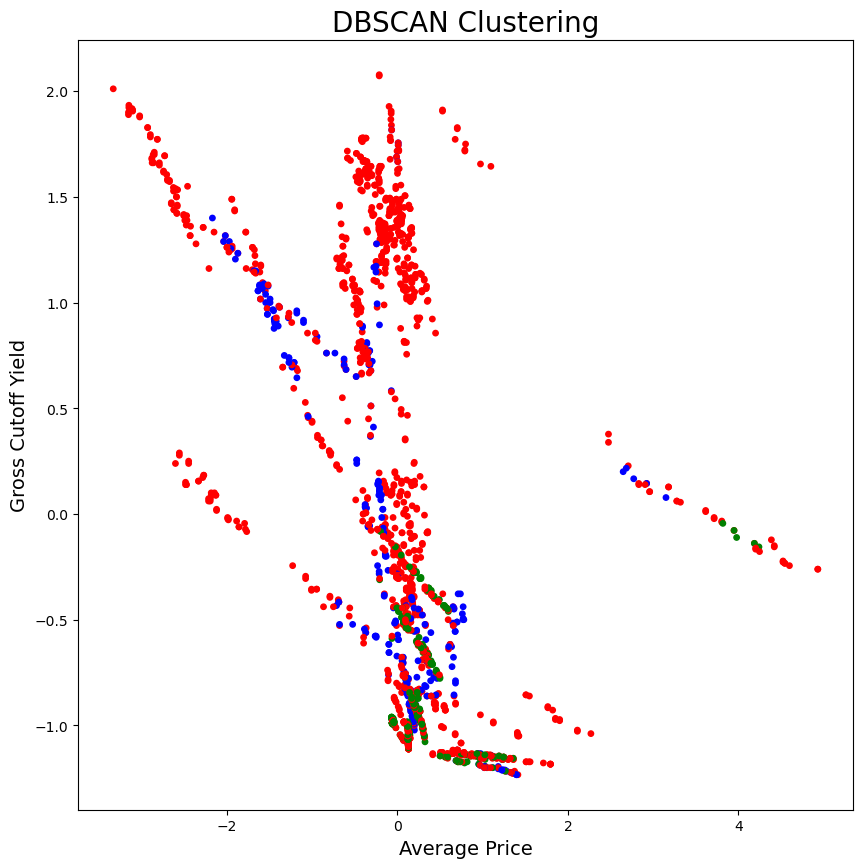

In [583]:
plt.figure(figsize=(10,10)) 
plt.scatter(unsuper_data['AVERAGEPRICE'],unsuper_data['GROSSCUTOFFYIELD'],c=unsuper_data['DBSCAN_labels'],cmap=matplotlib.colors.ListedColormap(colors),s=15) 
plt.title('DBSCAN Clustering',fontsize=20)
plt.xlabel('Average Price',fontsize=14)
plt.ylabel('Gross Cutoff Yield',fontsize=14)
plt.show()

In [585]:
from sklearn.metrics import silhouette_score

kmeans_silhouette = silhouette_score(unsuper_data, k_means.labels_)
hc_silhouette = silhouette_score(unsuper_data, y_pc_hc)
if len(set(dbscan_labels)) > 1:  # Ensure more than one cluster exists
    dbscan_silhouette = silhouette_score(unsuper_data[dbscan_labels != -1], dbscan_labels[dbscan_labels != -1])
else:
    dbscan_silhouette = "Not Applicable (only noise or one cluster)"
    
print(f"K-Means Silhouette Score: {kmeans_silhouette}")
print(f"Hierarchical Clustering Silhouette Score: {hc_silhouette}")
print(f"DBSCAN Silhouette Score: {dbscan_silhouette}")

K-Means Silhouette Score: 0.06350639784901331
Hierarchical Clustering Silhouette Score: -0.1111079645549738
DBSCAN Silhouette Score: 0.7177718102936972


In [587]:
labeled_data = unsuper_data[dbscan.labels_ != -1]
labeled_labels = dbscan.labels_[dbscan.labels_ != -1]

In [673]:
from sklearn.neighbors import KNeighborsClassifier

X_train, X_test, y_train, y_test = train_test_split(labeled_data, labeled_labels, test_size=0.2, random_state=42)

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

In [675]:
# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred, average = 'weighted'))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred, average = 'macro'))

print("F1 Score:",metrics.f1_score(y_test, y_pred, average = 'weighted'))

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


# עבודה שוטפת עם המאגר בגיטהאב
### עדכון שינויים:

In [625]:
!git add "Data Mining Supervised & Unsupervised 2025.ipynb"
!git commit -m "Added Supervised & Unsupervised analysis 2025 notebook update"
!git push origin main
!git push --set-upstream origin main

[main eda8929] Added Supervised & Unsupervised analysis 2025 notebook update
 1 file changed, 40 insertions(+), 35 deletions(-)


To https://github.com/DorNatan/data-mining-project-2025.git
   a3d41f6..eda8929  main -> main


branch 'main' set up to track 'origin/main'.


Everything up-to-date


In [626]:
!git add -u

In [629]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
